## Economia dos Games: Uma Análise Econômica sobre o Mercado da Steam por Johann Kotaro

### Importando bibliotecas e os dados

In [145]:
# Importar as Bibliotecas necessárias para a análise
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import re

In [146]:
# Carregar os dados
caminho = "SteamSpy - All the data and stats about Steam games.xlsx"
pd.set_option('display.max_rows', None) # Configura o pandas para tirar o limite de linhas que podem aparecer on output
df = pd.read_excel(caminho) # Criando um dataframe com os dados de excel

df.head()

,#,Game,Release date,Price,Score rank(Userscore / Metascore),Owners,Players,Playtime (Median)
0,1,Counter-Strike: Global Offensive,"Aug 21, 2012",Free,N/A (N/A/83%),"100,000,000 .. 200,000,000",0.1030,13:47 (05:15)
1,2,Dota 2,"Jul 9, 2013",Free,N/A (N/A/90%),"200,000,000 .. 500,000,000",0.0721,33:39 (17:09)
2,3,PUBG: BATTLEGROUNDS,"Dec 21, 2017",Free,N/A (N/A),"50,000,000 .. 100,000,000",0.0657,20:57 (06:06)
3,4,Wallpaper Engine,"Nov 1, 2018",3.99,N/A (N/A),"20,000,000 .. 50,000,000",0.1677,02:15 (00:13)
4,5,Call of Duty: Modern Warfare II,"Oct 27, 2022",99.99,N/A (N/A),"50,000,000 .. 100,000,000",0.0847,16:35 (08:11)


### Tratamento dos Dados

In [147]:
# Remove a coluna "Score rank"
df = df.drop('Score rank(Userscore / Metascore)', axis=1)
df = df.drop('#', axis=1)

In [148]:
# Converter para data a coluna "Release date"
df['Release date'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')

# Lidando com valores no formato "Mês Ano" (sem o dia)
df.loc[df['Release date'].isna(), 'Release date'] = pd.to_datetime(
    df.loc[df['Release date'].isna(), 'Release date'], format='%b %Y', errors='coerce'
)

# Extraindo o ano de "Release date"
df['Release Year'] = pd.DatetimeIndex(df['Release date']).year

In [149]:
# Ajustar a coluna 'Price' (substituindo 'Free' por 0 e convertendo para float (decimal))
df['Price'] = df['Price'].replace('Free', '0').astype(float)

In [150]:
# Criar uma Função para limpar e converter a coluna 'Owners'
def convert_owners(owner_range):
    # Remover caracteres especiais e espaços
    owner_range = owner_range.replace('\xa0', '').replace(',', '')
    
    # Se o valor contiver '..', trata como intervalo ((min+max)/2)
    if '..' in owner_range:
        lower, upper = owner_range.split('..')
        return (int(lower) + int(upper)) / 2
    else:
        # Caso o valor não seja um intervalo, tentar converter para número
        try:
            return int(owner_range)
        except ValueError:
            # Caso não consiga, retornar um valor NaN ou 0
            return np.nan

# Aplicar a conversão
df['Owners'] = df['Owners'].apply(convert_owners)

# Verificando o resultado
print(df[['Game', 'Owners']].head())

                               Game       Owners
0  Counter-Strike: Global Offensive  150000000.0
1                            Dota 2  350000000.0
2               PUBG: BATTLEGROUNDS   75000000.0
3                  Wallpaper Engine   35000000.0
4   Call of Duty: Modern Warfare II   75000000.0


In [151]:
# Criar uma Função para remover a mediana da coluna 'Playtime (Median)'
def remove_median(playtime):
    # Remove a parte entre parênteses
    return re.sub(r'\s\([^)]*\)', '', playtime)

# Aplicar a Função para limpar a coluna 'Playtime (Median)'
df['Playtime (Median)'] = df['Playtime (Median)'].apply(remove_median)

# Ajustar a coluna 'Playtime (Median)' (converte para minutos)
def convert_playtime(playtime):
    time = playtime.split(' ')[0]
    minutes, seconds = map(int, time.split(':'))
    return minutes + seconds / 60

# Aplicar a Função para ajustar a coluna 'Playtime (Median)'
df['Playtime (Median)'] = df['Playtime (Median)'].apply(convert_playtime)

# Mudar o nome de 'Playtime (Median)' para 'Average Playtime' (Tempo Médio de Jogo)
df.rename(columns={'Playtime (Median)': 'Average Playtime'}, inplace=True)

In [152]:
# Preencher NaN (valores vazios) com a média (para números)
df['Price'] = df['Price'].fillna(df['Price'].mean())
df['Owners'] = df['Owners'].fillna(df['Owners'].mean())
df['Average Playtime'] = df['Average Playtime'].fillna(df['Average Playtime'].mean())

# Ou, se preferir, excluir as linhas com NaN
# df = df.dropna(subset=['Price', 'Owners', 'Average Playtime'])

### Regressões Lineares de Preço e Número de Donos e Preço e Tempo Médio de Jogo

#### Matriz de correlação

In [153]:
# Matriz de correlação
correlation_matrix = df[['Price', 'Owners', 'Players', 'Average Playtime']].corr()
print(correlation_matrix)

                     Price    Owners   Players  Average Playtime
Price             1.000000 -0.028502  0.101390         -0.176205
Owners           -0.028502  1.000000 -0.124077          0.038551
Players           0.101390 -0.124077  1.000000         -0.001436
Average Playtime -0.176205  0.038551 -0.001436          1.000000


#### Regressões Lineares pré-ajustes

In [154]:
# Regressão entre Preço e Número de Donos (Modelo 1)
X = df['Price']
y = df['Owners']
X = sm.add_constant(X)  # Adiciona constante para o modelo de regressão
model = sm.OLS(y, X).fit()
print("Regressão entre Preço e Número de Donos:")
print(model.summary())

# Regressão entre Preço e Tempo Médio de Jogo (Modelo 2)
y2 = df['Average Playtime']
model2 = sm.OLS(y2, X).fit()
print("Regressão entre Preço e Tempo Médio de Jogo:")
print(model2.summary())

Regressão entre Preço e Número de Donos:
                            OLS Regression Results                            
Dep. Variable:                 Owners   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2927
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.589
Time:                        21:01:27   Log-Likelihood:                -6666.1
No. Observations:                 362   AIC:                         1.334e+04
Df Residuals:                     360   BIC:                         1.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

#### Teste de Homoscedasticidade

In [155]:
# Teste de Homoscedasticidade (Breusch-Pagan)

from statsmodels.stats.diagnostic import het_breuschpagan

print("Teste de Homoscedasticidade Modelo 1:")
# Obtém os resíduos e ajustados do modelo 1
residuals = model.resid
fitted = model.fittedvalues

# Aplica o teste de Breusch-Pagan no Modelo 1
bp_test = het_breuschpagan(residuals, sm.add_constant(fitted))
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(bp_labels, bp_test)))

print("")
print("Teste de Homoscedasticidade Modelo 2:")

# Obtém os resíduos e ajustados do modelo 1
residuals2 = model2.resid
fitted2 = model2.fittedvalues

# Aplica o teste de Breusch-Pagan no Modelo 1
bp_test2 = het_breuschpagan(residuals2, sm.add_constant(fitted2))
bp_labels2 = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(bp_labels2, bp_test2)))

Teste de Homoscedasticidade Modelo 1:
{'Lagrange multiplier statistic': 1.2302739794124535, 'p-value': 0.26735376221893836, 'f-value': 1.227649108681614, 'f p-value': 0.26860442833869236}

Teste de Homoscedasticidade Modelo 2:
{'Lagrange multiplier statistic': 8.899580065073522, 'p-value': 0.0028523624592419637, 'f-value': 9.073477805596822, 'f p-value': 0.00277681148795267}


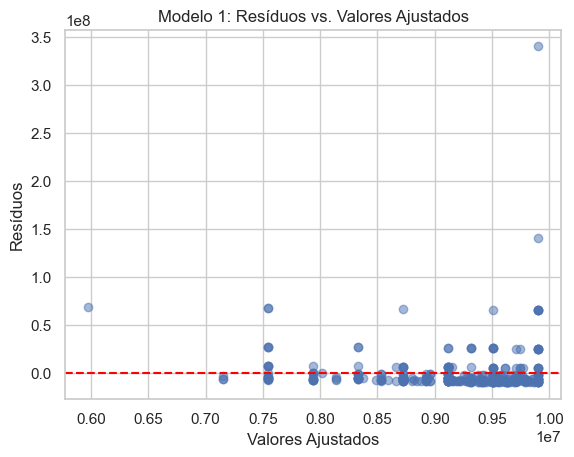

In [156]:
# Criar um Gráfico de Resíduos vs. Ajustados do Modelo 1
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Modelo 1: Resíduos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()


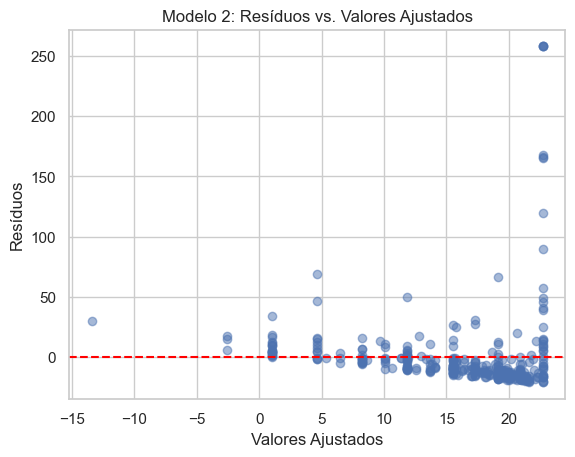

In [157]:
# Criar um Gráfico de Resíduos vs. Ajustados do Modelo 2
plt.scatter(fitted2, residuals2, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Modelo 2: Resíduos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()


#### Teste de Independência

In [158]:
# Teste de Independência (Durbin-Watson)
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
dw_stat2 = durbin_watson(residuals2)
print(f'Estatística de Durbin-Watson do Modelo 1: {dw_stat}')
print(f'Estatística de Durbin-Watson do Modelo 2: {dw_stat}')

Estatística de Durbin-Watson do Modelo 1: 0.9632342725629339
Estatística de Durbin-Watson do Modelo 2: 0.9632342725629339


#### Teste de Normalidade

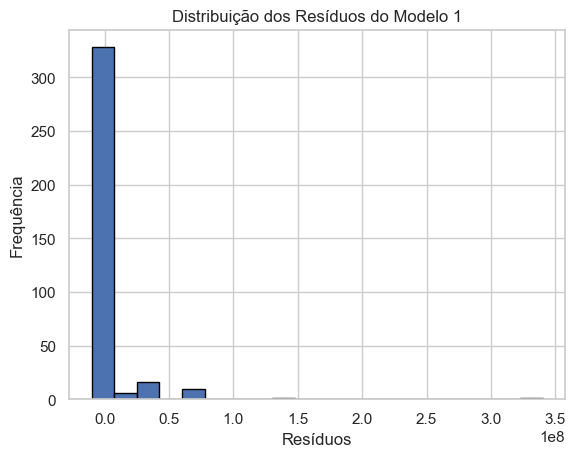

In [159]:
# Criar um Histograma dos Resíduos do Modelo 1
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Distribuição dos Resíduos do Modelo 1')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()


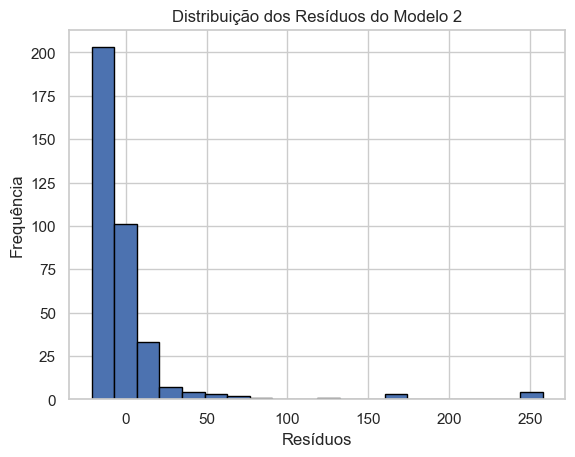

In [160]:
# Criar um Histograma dos Resíduos do Modelo 2
plt.hist(residuals2, bins=20, edgecolor='black')
plt.title('Distribuição dos Resíduos do Modelo 2')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()


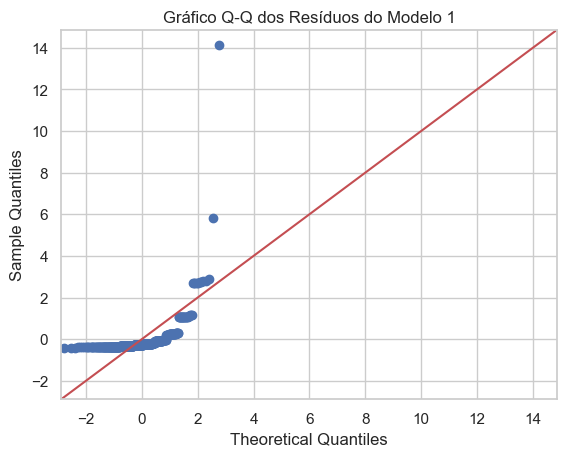

In [161]:
# Criar um Gráfico Q-Q (Quantile-Quantile) do Modelo 1
sm.qqplot(residuals, line='45', fit=True)
plt.title('Gráfico Q-Q dos Resíduos do Modelo 1')
plt.show()

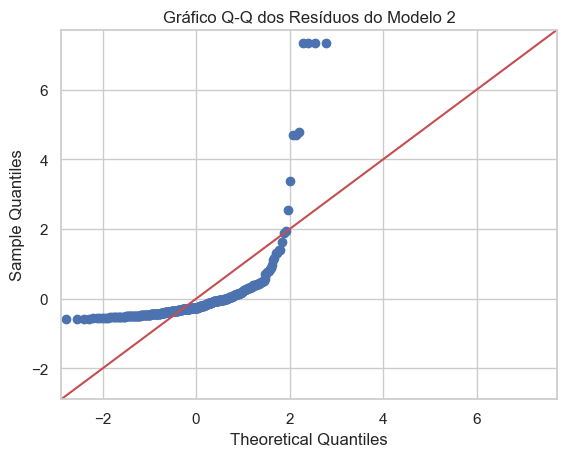

In [162]:
# Criar um Gráfico Q-Q (Quantile-Quantile) do Modelo 2
sm.qqplot(residuals2, line='45', fit=True)
plt.title('Gráfico Q-Q dos Resíduos do Modelo 2')
plt.show()

In [163]:
# Teste de Normalidade (Teste de Shapiro-Wilk)
from scipy.stats import shapiro

shapiro_test = shapiro(residuals)
shapiro_test2 = shapiro(residuals2)
print(f'Teste de Shapiro-Wilk: Estatística={shapiro_test.statistic}, p-valor={shapiro_test.pvalue}')
print(f'Teste de Shapiro-Wilk: Estatística={shapiro_test2.statistic}, p-valor={shapiro_test2.pvalue}')

Teste de Shapiro-Wilk: Estatística=0.34151275928572666, p-valor=5.002202067795773e-34
Teste de Shapiro-Wilk: Estatística=0.4238064099863533, p-valor=2.2435833016754395e-32


#### Ajustes para o Modelo 1 e Modelo 2

In [164]:
# Regressão entre Preço e Número de Donos para o (Modelo 1) com transformação logarítmica
X1 = np.log(df['Price'] + 1)  # Transformação logarítmica para lidar com distribuição
y1 = np.log(df['Owners'] + 1)
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit()
print("\nRegressão entre Preço e Número de Donos (com transformação logarítmica):")
print(model1.summary())


Regressão entre Preço e Número de Donos (com transformação logarítmica):
                            OLS Regression Results                            
Dep. Variable:                 Owners   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.667
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.103
Time:                        21:01:29   Log-Likelihood:                -704.51
No. Observations:                 362   AIC:                             1413.
Df Residuals:                     360   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [165]:
from statsmodels.regression.linear_model import GLSAR

# Ajuste com modelo autorregressivo para lidar com autocorrelação (Modelo 1)
glsar_model1 = GLSAR(y1, X1, rho=1)
results_glsar1 = glsar_model1.iterative_fit(maxiter=10)
print("\nModelo GLSAR para Número de Donos:")
print(results_glsar1.summary())


Modelo GLSAR para Número de Donos:
                           GLSAR Regression Results                           
Dep. Variable:                 Owners   R-squared:                       0.000
Model:                          GLSAR   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.01389
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.906
Time:                        21:01:29   Log-Likelihood:                -676.84
No. Observations:                 361   AIC:                             1358.
Df Residuals:                     359   BIC:                             1365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14

In [166]:
# Regressão entre Preço e Tempo Médio de Jogo (Modelo 2) com erros padrão robustos
y2 = df['Average Playtime']
model2 = sm.OLS(y2, X1).fit(cov_type='HC3')  # Erros padrão robustos
print("\nRegressão entre Preço e Tempo Médio de Jogo (com erros padrão robustos):")
print(model2.summary())


Regressão entre Preço e Tempo Médio de Jogo (com erros padrão robustos):
                            OLS Regression Results                            
Dep. Variable:       Average Playtime   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     15.57
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           9.56e-05
Time:                        21:01:29   Log-Likelihood:                -1777.9
No. Observations:                 362   AIC:                             3560.
Df Residuals:                     360   BIC:                             3568.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [167]:
# Ajuste com modelo autorregressivo para lidar com autocorrelação (Modelo 2)
glsar_model2 = GLSAR(y2, X1, rho=1)
results_glsar2 = glsar_model2.iterative_fit(maxiter=10)
print("\nModelo GLSAR para Tempo Médio de Jogo:")
print(results_glsar2.summary())


Modelo GLSAR para Tempo Médio de Jogo:
                           GLSAR Regression Results                           
Dep. Variable:       Average Playtime   R-squared:                       0.135
Model:                          GLSAR   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     55.83
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           6.07e-13
Time:                        21:01:29   Log-Likelihood:                -1663.4
No. Observations:                 361   AIC:                             3331.
Df Residuals:                     359   BIC:                             3339.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [168]:
# Normalidade dos resíduos do Modelo 1
residuals_model1 = model1.resid
shapiro_test_model1 = shapiro(residuals_model1)
residuals_model2 = model2.resid
shapiro_test_model2 = shapiro(residuals_model2)
print(f"\nTeste de Shapiro-Wilk (Modelo 1): Estatística={shapiro_test_model1.statistic}, p-valor={shapiro_test_model1.pvalue}")
print(f"Teste de Shapiro-Wilk (Modelo 2): Estatística={shapiro_test_model2.statistic}, p-valor={shapiro_test_model2.pvalue}")



Teste de Shapiro-Wilk (Modelo 1): Estatística=0.9871513597097571, p-valor=0.002711714682808742
Teste de Shapiro-Wilk (Modelo 2): Estatística=0.5637399289381586, p-valor=4.514138484359843e-29


### Análise Temporal

#### Agrupando o DataFrame pelo Ano de Lançamento

In [169]:
# Agrupamento por ano
temporal_analysis = df.groupby('Release Year').agg({
    'Price': 'mean',
    'Owners': 'mean',
    'Players': 'mean',
    'Average Playtime': 'mean'
}).reset_index()

print(temporal_analysis)

    Release Year      Price        Owners   Players  Average Playtime
0           1970  34.990000  1.500000e+06  0.067800          0.583333
1           1994   0.000000  7.500000e+06  0.039500         27.933333
2           1998   9.990000  1.500000e+07  0.009000          1.550000
3           2000   9.990000  1.500000e+07  0.013200         12.683333
4           2002   4.990000  3.500000e+05  0.058800          5.600000
5           2003   0.000000  3.500000e+06  0.012500        190.766667
6           2004   9.990000  1.500000e+07  0.038000          4.983333
7           2005  24.990000  3.500000e+05  0.007400          7.816667
8           2006   9.990000  3.500000e+07  0.024400         31.716667
9           2007   0.000000  7.500000e+07  0.019200         37.750000
10          2009   8.992000  1.654000e+07  0.044180         59.526667
11          2010  14.992500  7.375000e+06  0.013700         12.183333
12          2011  12.490000  1.356250e+07  0.023200          9.616667
13          2012   6

#### Gráficos para Análise Temporal

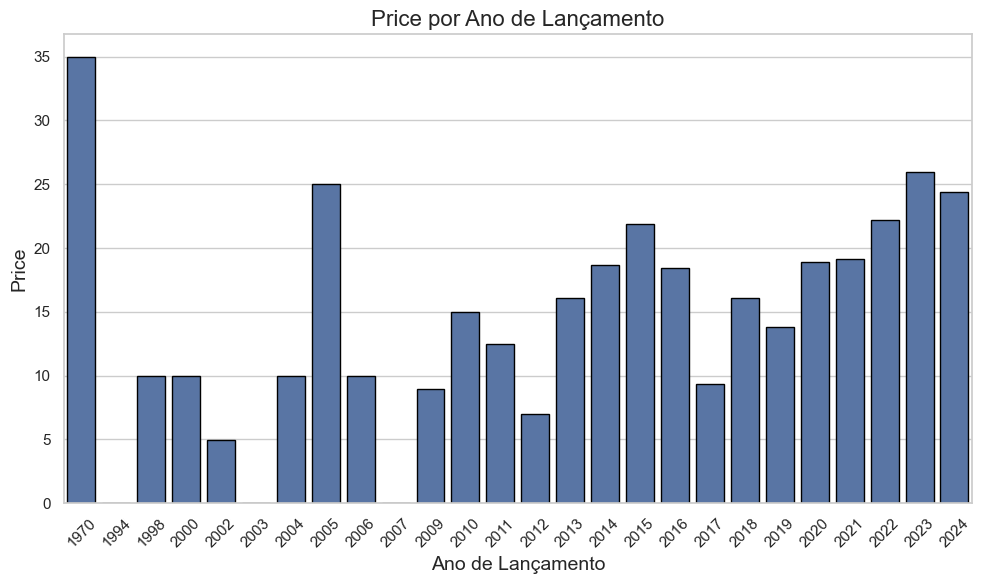

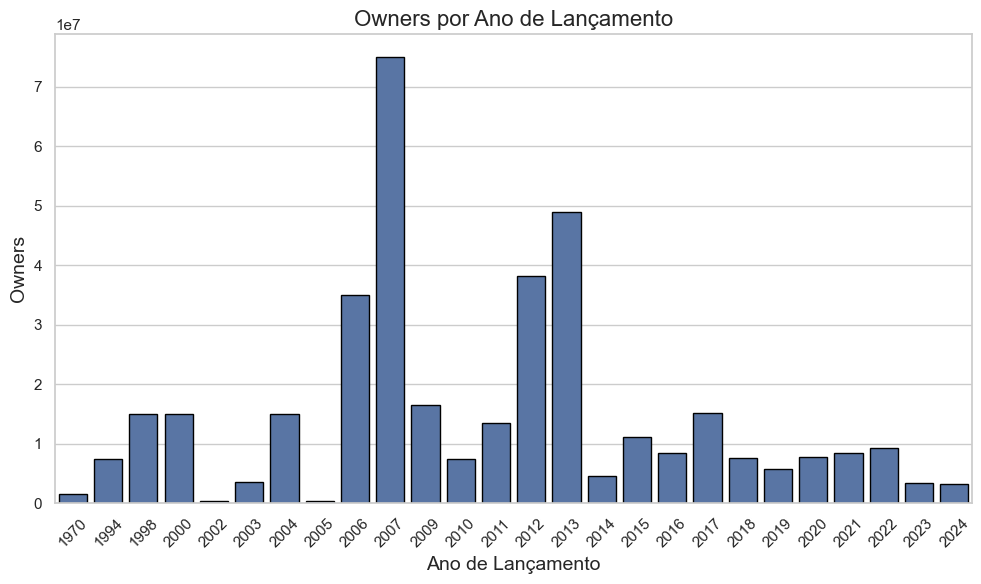

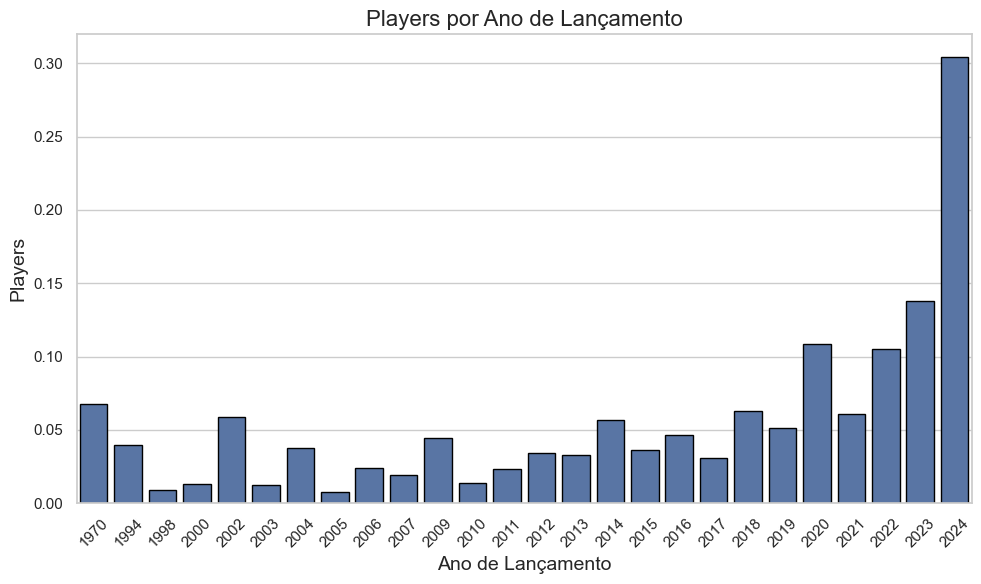

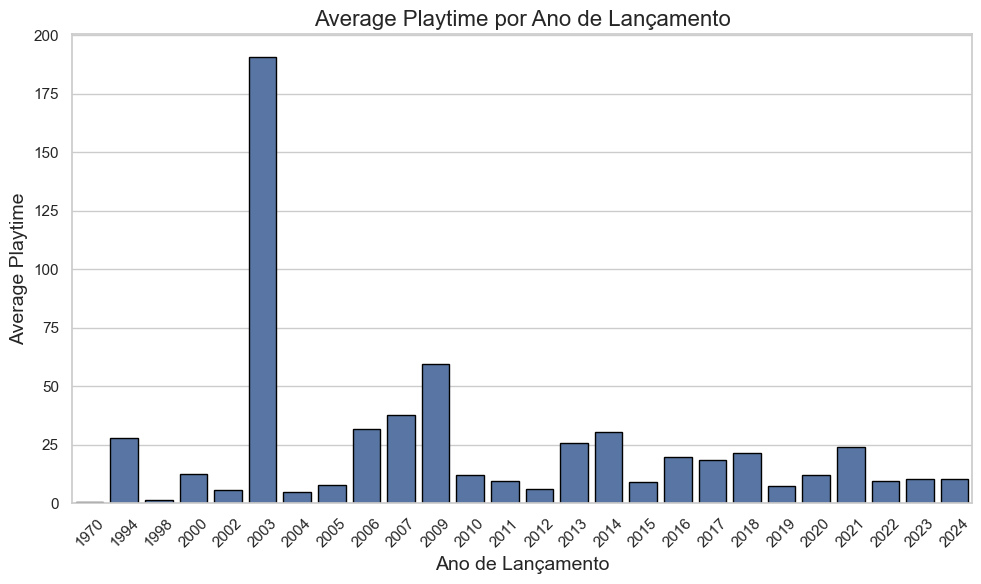

In [170]:
import seaborn as sns

# Configuração estética do Seaborn
sns.set_theme(style="whitegrid")

# Repetir criação um gráfico para cada métrica
metrics = ['Price', 'Owners', 'Players', 'Average Playtime']
for metric in metrics:
    plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico
    sns.barplot(data=temporal_analysis, x='Release Year', y=metric, edgecolor='black')
    plt.title(f'{metric} por Ano de Lançamento', fontsize=16)
    plt.xlabel('Ano de Lançamento', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
    plt.tight_layout()  # Ajusta o layout para evitar cortes
    plt.show()


### Análise de Elasticidade Preço x Donos

In [171]:
# Filtrar jogos com preço > 0 para evitar log(0)
df_filtered = df[df['Price'] > 0].copy()
df_filtered['log_Price'] = np.log(df_filtered['Price'])
df_filtered['log_Owners'] = np.log(df_filtered['Owners'])

# Regressão log-log
X = df_filtered['log_Price']
y = df_filtered['log_Owners']
X = sm.add_constant(X)
model_loglog = sm.OLS(y, X).fit()
print(model_loglog.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Owners   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.224
Date:                Thu, 05 Dec 2024   Prob (F-statistic):             0.0131
Time:                        21:01:32   Log-Likelihood:                -609.82
No. Observations:                 324   AIC:                             1224.
Df Residuals:                     322   BIC:                             1231.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8991      0.291     47.781      0.0

### Distribuição dos Preços

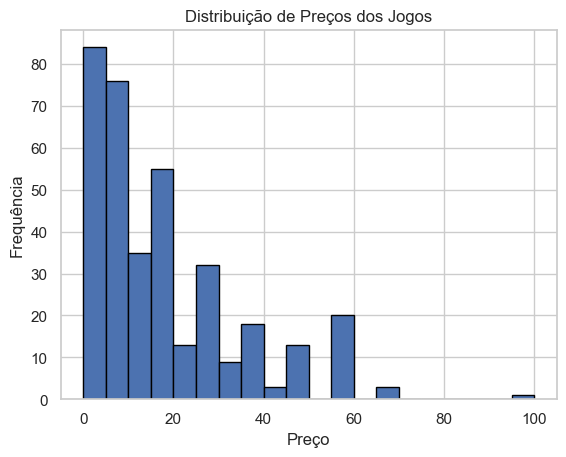

In [172]:
# Histograma de preços de 20 bins
plt.hist(df['Price'], bins=20, edgecolor='black')
plt.title('Distribuição de Preços dos Jogos')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

### Análise de Engajamento (% Jogadores Ativos)

In [173]:
# Classificar jogos por engajamento ('Baixo Engajamento', 'Médio Engajamento', 'Alto Engajamento')
bins = [0, 0.1, 0.5, 1]
labels = ['Baixo Engajamento', 'Médio Engajamento', 'Alto Engajamento']
df['Engagement Tier'] = pd.cut(df['Players'], bins=bins, labels=labels)

# Análise descritiva por tier
engagement_analysis = df.groupby('Engagement Tier', observed=True).agg({
    'Price': 'mean',
    'Owners': 'mean',
    'Average Playtime': 'mean'
}).reset_index()

print(engagement_analysis)

     Engagement Tier      Price        Owners  Average Playtime
0  Baixo Engajamento  18.004376  1.079356e+07         14.391793
1  Médio Engajamento  22.128861  5.747468e+06         20.067089
2   Alto Engajamento  23.112105  4.715789e+05         17.541228


### Relação entre Número de Donos e Porcentagem de Jogadores Ativos

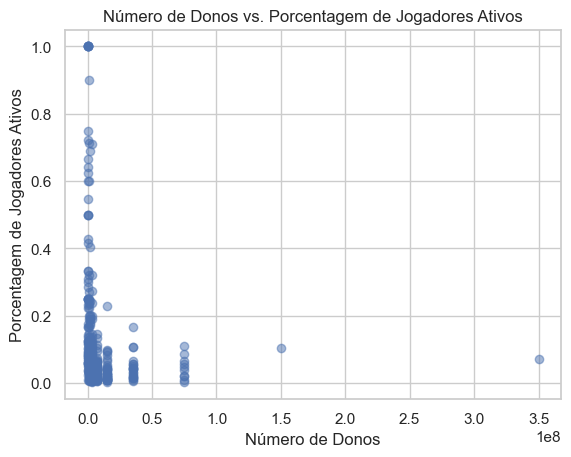

In [174]:
# Scatter plot
plt.scatter(df['Owners'], df['Players'], alpha=0.5)
plt.title('Número de Donos vs. Porcentagem de Jogadores Ativos')
plt.xlabel('Número de Donos')
plt.ylabel('Porcentagem de Jogadores Ativos')
plt.show()

### Jogos Gratuitos vs. Jogos Pagos

In [176]:
# Definir como de 'gratuito' quando o price = 0, se não é 'pago'
df['Free or Paid'] = df['Price'].apply(lambda x: 'Free' if x == 0 else 'Paid')

# Comparação entre Jogos Gratuito e Jogos Pagos
comparison = df.groupby('Free or Paid').agg({
    'Owners': 'mean',
    'Players': 'mean',
    'Average Playtime': 'mean'
}).reset_index()

print(comparison)

  Free or Paid        Owners   Players  Average Playtime
0         Free  3.194895e+07  0.047932         72.690351
1         Paid  6.476698e+06  0.121997          9.122788
